## MSDI Combined Analysis

In [1]:
import pandas as pd
import numpy as np
import tables
import h5py
import pickle

import math
import random

import os, sys, glob
from pathlib import Path

import keras
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten, Conv2D, Dropout, MaxPooling2D, BatchNormalization

import tensorflow as tf

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import requests

def download_file_from_google_drive(id, destination):
    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value

        return None

    def save_response_content(response, destination):
        CHUNK_SIZE = 3276800

        with open(destination, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)

    URL = "https://drive.google.com/u/0/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    




In [ ]:
# TAKE ID FROM SHAREABLE LINK
#https://drive.google.com/file/d/1wduOo4DLWGEAF44odjv6BQlsxYsO_0c6/view?usp=sharing
file_id = r'1wduOo4DLWGEAF44odjv6BQlsxYsO_0c6'
# DESTINATION FILE ON YOUR DISK
destination = 'shortlisted_tracks_df.pkl' #pickle4
download_file_from_google_drive(file_id, destination)

In [ ]:
# TAKE ID FROM SHAREABLE LINK
#https://drive.google.com/file/d/1dhgh0ZPptiqBFHZ1vPhBU6-GH39k2NPY/view?usp=sharing
file_id = r'1dhgh0ZPptiqBFHZ1vPhBU6-GH39k2NPY'
# DESTINATION FILE ON YOUR DISK
destination = 'msd_data.zip'
download_file_from_google_drive(file_id, destination)

In [ ]:
!rm -rf msd_data
!unzip -q msd_data.zip

In [ ]:
# TAKE ID FROM SHAREABLE LINK
#https://drive.google.com/file/d/1T3uoNvxdC-u7ImJf8xOkqRssQio_WmKf/view?usp=sharing
file_id = r'1T3uoNvxdC-u7ImJf8xOkqRssQio_WmKf'
# DESTINATION FILE ON YOUR DISK
destination = 'lyric_df.pkl' #pickle4
download_file_from_google_drive(file_id, destination)

In [ ]:
# TAKE ID FROM SHAREABLE LINK
#https://drive.google.com/file/d/16VKAXPeAbqbOSrfZp2SSBajh3KezftuM/view?usp=sharing
file_id = r'16VKAXPeAbqbOSrfZp2SSBajh3KezftuM'
# DESTINATION FILE ON YOUR DISK
destination = 'aart_data.zip'
download_file_from_google_drive(file_id, destination)

In [ ]:
!rm -rf aart_data
!unzip -q aart_data.zip

In [ ]:
with open('shortlisted_tracks_df' +'.pkl', 'rb') as handle:
    shortlisted_tracks_df = pickle.load(handle)

In [ ]:
shortlisted_tracks_df

,Genre
TrackId,
TREQVVI128F427C38E,Country
TRYCYSD128F148CF20,Country
TRLCZET12903D03F70,Country
TRJORPT128F42BAA8D,Country
TROBJYA128F42A2984,Country
...,...
TRQFZEO128E07930BC,Rock
TRNSWUN128F4247F87,Rock
TRLENOU128F4281E94,Rock


In [ ]:
track_genre_df = shortlisted_tracks_df.sample(frac=1, random_state=1)
track_genre_df

,Genre
TrackId,
TRQNZED128F42968DB,Electronic
TRNXIPI128F93038E3,Rock
TRMXKFV128F428EFF3,Pop
TRZBVCE128F92C2951,Metal
TRNOFGZ128E07860D0,Rap
...,...
TRIARZC12903CB4BC4,Rap
TRBNQWY128F4257C00,Pop
TRTSSYQ128F42BCDD4,Electronic


In [ ]:
track_count = len(track_genre_df.index.values)
track_count

4900

In [ ]:
genre_labels = list(track_genre_df['Genre'].unique())
genre_count = len(genre_labels)
print(genre_labels, "count: ", genre_count)

['Electronic', 'Rock', 'Pop', 'Metal', 'Rap', 'RnB', 'Country'] count:  7


In [ ]:
with open('lyric_df' +'.pkl', 'rb') as handle:
    lyric_df = pickle.load(handle)

In [ ]:
lyric_df

,Genre,wordvec
TrackId,,
TREQVVI128F427C38E,Country,"[8, 3, 7, 4, 9, 2, 3, 3, 2, 2, 7, 1, 0, 0, 7, ..."
TRYCYSD128F148CF20,Country,"[14, 4, 37, 0, 3, 0, 1, 0, 0, 3, 4, 0, 4, 3, 2..."
TRLCZET12903D03F70,Country,"[5, 17, 0, 6, 8, 14, 1, 0, 0, 8, 4, 1, 7, 0, 0..."
TRJORPT128F42BAA8D,Country,"[16, 3, 14, 7, 1, 6, 3, 2, 9, 0, 0, 4, 0, 3, 7..."
TROBJYA128F42A2984,Country,"[13, 5, 10, 8, 4, 2, 0, 1, 7, 1, 0, 1, 2, 2, 5..."
...,...,...
TRQFZEO128E07930BC,Rock,"[35, 7, 23, 10, 5, 1, 0, 9, 6, 0, 0, 4, 0, 5, ..."
TRNSWUN128F4247F87,Rock,"[8, 9, 0, 4, 3, 6, 0, 0, 0, 8, 1, 3, 0, 0, 2, ..."
TRLENOU128F4281E94,Rock,"[0, 0, 0, 0, 0, 24, 62, 0, 0, 0, 0, 0, 0, 0, 0..."


In [ ]:
msdi_genres = np.zeros((track_count, genre_count), dtype=np.float32)
for i, track_id in enumerate(track_genre_df.index.values):
  msdi_genres[i][genre_labels.index(track_genre_df['Genre'].iloc[i])] = 1

In [ ]:
modelling_test_size = 0.3
y_train, y_test = train_test_split(msdi_genres, test_size=modelling_test_size, random_state=1)

In [ ]:
mfcc_count = 12
seg_count = 512
msdi_mfcc_values = np.zeros((track_count, mfcc_count), dtype=np.float32)
#msdi_mfcc_values = np.zeros((track_count, seg_count, mfcc_count), dtype=np.float32)
track_seg_counts = []

for i, track_id in enumerate(track_genre_df.index.values):
    filepath = 'msd_data/' + track_id[2] + '/' + track_id[3] + '/' + track_id[4] + '/' + track_id + '.h5'
    try:
      hfile = h5py.File(filepath, 'r')
      track_mfcc_tmp = np.array(hfile['analysis']['segments_timbre'])
      '''track_seg_counts.append(track_mfcc_tmp.shape[0])
      track_seg_count = min(track_mfcc_tmp.shape[0], seg_count)
      fill_count = 0
      while fill_count < seg_count:
        fill_count_tmp = min(track_seg_count, (seg_count-fill_count))
        msdi_mfcc_values[i][fill_count:fill_count+fill_count_tmp] = track_mfcc_tmp[:fill_count_tmp]
        fill_count = fill_count + fill_count_tmp
      '''
      msdi_mfcc_values[i] = np.mean(track_mfcc_tmp, axis=0)
      hfile.close()
    except (RuntimeError, TypeError, NameError, OSError):
      print('failed for file: ', filepath)

In [ ]:
x_train_mfcc, x_test_mfcc = train_test_split(msdi_mfcc_values, test_size=modelling_test_size, random_state=1)
msdi_mfcc_values = None

In [ ]:
def get_mfcc_model_cnn(input_shape, num_classes):

  model = Sequential()
  model.add(Dense(256, input_shape=input_shape, activation='relu', kernel_initializer='he_uniform'))
  #model.add(BatchNormalization())

  model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dropout(0.25))

  model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dropout(0.5))

  model.add(Dense(num_classes, activation='softmax', kernel_initializer='he_uniform'))
  #opt = tf.keras.optimizers.Adam(lr=0.0001)
  model.compile(loss=keras.losses.categorical_crossentropy,
              #optimizer=opt,
              optimizer='adam',
              metrics=['accuracy'])
  #model.summary
  return model

In [ ]:
x_train = x_train_mfcc#np.std(x_train_mfcc, axis=1)
x_test = x_test_mfcc#np.std(x_test_mfcc, axis=1)
input_shape = (x_train.shape[1], )
model = get_mfcc_model_cnn(input_shape, genre_count)
#x_train = x_train_mfcc.reshape(x_train_mfcc.shape[0], x_train_mfcc.shape[1], mfcc_count, 1)
#x_test = x_test_mfcc.reshape(x_test_mfcc.shape[0], x_train_mfcc.shape[1], mfcc_count, 1)


callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)
history_mfcc = model.fit(x_train, y_train, epochs=100, batch_size=128, callbacks=[callback], verbose=1, validation_data=(x_test, y_test))
model_mfcc = model

Epoch 1/100
27/27 [==============================] - 2s 15ms/step - loss: 27.5432 - accuracy: 0.2688 - val_loss: 4.8857 - val_accuracy: 0.4544
Epoch 2/100
27/27 [==============================] - 0s 8ms/step - loss: 6.5420 - accuracy: 0.3364 - val_loss: 1.6822 - val_accuracy: 0.4408
Epoch 3/100
27/27 [==============================] - 0s 8ms/step - loss: 3.1433 - accuracy: 0.3306 - val_loss: 1.6293 - val_accuracy: 0.3803
Epoch 4/100
27/27 [==============================] - 0s 7ms/step - loss: 2.1160 - accuracy: 0.3149 - val_loss: 1.6911 - val_accuracy: 0.3667
Epoch 5/100
27/27 [==============================] - 0s 8ms/step - loss: 1.8770 - accuracy: 0.3341 - val_loss: 1.6283 - val_accuracy: 0.3918
Epoch 6/100
27/27 [==============================] - 0s 8ms/step - loss: 1.7810 - accuracy: 0.3466 - val_loss: 1.6405 - val_accuracy: 0.4095
Epoch 7/100
27/27 [==============================] - 0s 8ms/step - loss: 1.7170 - accuracy: 0.3671 - val_loss: 1.5971 - val_accuracy: 0.4272
Epoch 8/100

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings

warnings.filterwarnings('ignore')
x_train = x_train_mfcc

grid={"C":[0.001, 0.01, 0.1, 1, 10], 'solver':['lbfgs', 'sag', 'newton-cg']} #only l2 supported

logreg = LogisticRegression(multi_class='multinomial')
gcv=GridSearchCV(logreg,grid,cv=5,scoring='accuracy')
gcv.fit(x_train, np.argmax(y_train, axis=1))

print("tuned hpyerparameters :(best parameters) ",gcv.best_params_)
print("accuracy :",gcv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'solver': 'newton-cg'}
accuracy : 0.5244897959183674


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings

warnings.filterwarnings('ignore')
x_train = x_train_mfcc
x_test = x_test_mfcc

model = LogisticRegression(multi_class='multinomial', C=0.01, solver='newton-cg')

model.fit(x_train, np.argmax(y_train, axis=1))
y_test_pred = model.predict(x_test)
print("test accuracy : ", accuracy_score(np.argmax(y_test, axis=1), y_test_pred))

test accuracy :  0.5435374149659864


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import warnings

warnings.filterwarnings('ignore')
x_train = x_train_mfcc

grid={"leaf_size":range(1,10), "p":[1,2]}
knn = KNeighborsClassifier(n_neighbors=genre_count)
gcv=GridSearchCV(knn,grid,cv=5,scoring='accuracy')
gcv.fit(x_train, np.argmax(y_train, axis=1))

print("tuned hpyerparameters :(best parameters) ",gcv.best_params_)
print("accuracy :",gcv.best_score_)

tuned hpyerparameters :(best parameters)  {'leaf_size': 1, 'p': 1}
accuracy : 0.4568513119533528


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import warnings

warnings.filterwarnings('ignore')
x_train = x_train_mfcc

model = KNeighborsClassifier(n_neighbors=genre_count, leaf_size=1, p=1)

model.fit(x_train, np.argmax(y_train, axis=1))
y_test_pred = model.predict(x_test)
print("test accuracy : ", accuracy_score(np.argmax(y_test, axis=1), y_test_pred))

test accuracy :  0.46802721088435373


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import warnings

warnings.filterwarnings('ignore')
x_train = x_train_mfcc

grid={"kernel":['linear', 'poly', 'rbf'], "C":[0.001, 0.1, 1, 10, 100, 1000], 'gamma': [0.001, 0.01, 0.1, 1]}
#grid={"C":[0.001, 0.1, 1, 10, 100, 1000]}
#grid={'gamma': [0.001, 0.01, 0.1, 1]}
svn = SVC()
gcv=GridSearchCV(svn,grid,cv=5,scoring='accuracy')
gcv.fit(x_train, np.argmax(y_train, axis=1))

print("tuned hpyerparameters :(best parameters) ",gcv.best_params_)
print("accuracy :",gcv.best_score_)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import warnings

warnings.filterwarnings('ignore')
x_train = x_train_mfcc

model = SVC(kernel='rbf', C=10, gamma=.0001)

model.fit(np.mean(x_train, axis=1), np.argmax(y_train, axis=1))
y_test_pred = model.predict(np.mean(x_test, axis=1))
print("test accuracy : ", accuracy_score(np.argmax(y_test, axis=1), y_test_pred))

test accuracy :  0.5476190476190477


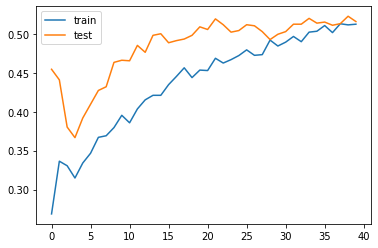

In [ ]:
plt.plot(history_mfcc.history['accuracy'], label='train')
plt.plot(history_mfcc.history['val_accuracy'], label='test')
plt.legend()
plt.show()

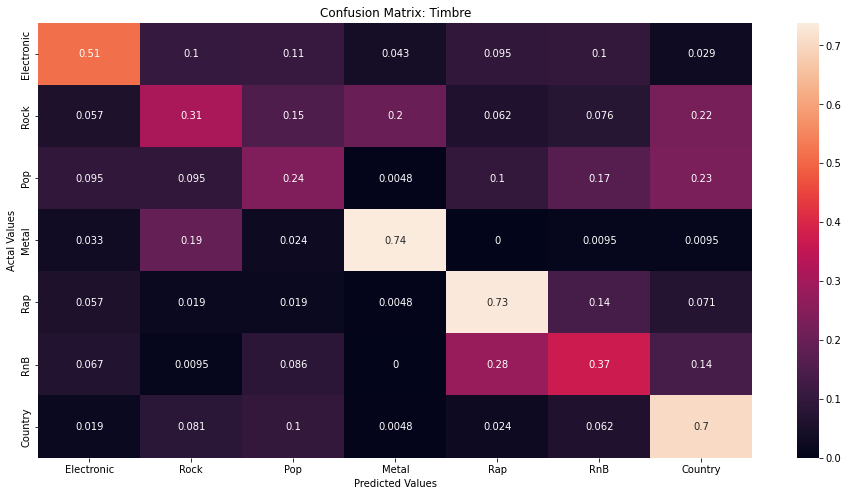

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = model_mfcc.predict(x_test_mfcc)
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
cm_df = pd.DataFrame(cm*genre_count/cm.sum(), index = genre_labels, columns = genre_labels)

#Plotting the confusion matrix
plt.figure(figsize=(16,8))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix: Timbre')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=genre_labels))


Classification Report

              precision    recall  f1-score   support

  Electronic       0.61      0.52      0.56       209
        Rock       0.38      0.29      0.33       227
         Pop       0.33      0.26      0.29       195
       Metal       0.74      0.73      0.74       211
         Rap       0.57      0.70      0.63       219
         RnB       0.40      0.39      0.40       200
     Country       0.50      0.71      0.59       209

    accuracy                           0.52      1470
   macro avg       0.50      0.51      0.50      1470
weighted avg       0.51      0.52      0.51      1470



In [ ]:
seg_count = 1024
chroma_count = 12

msdi_chroma_values = np.zeros((track_count, chroma_count), dtype=np.float32)
#msdi_chroma_values = np.zeros((track_count, seg_count, chroma_count), dtype=np.float32)

for i, track_id in enumerate(track_genre_df.index.values):
    filepath = 'msd_data/' + track_id[2] + '/' + track_id[3] + '/' + track_id[4] + '/' + track_id + '.h5'
    try:
      hfile = h5py.File(filepath, 'r')
      track_chroma_tmp = np.array(hfile['analysis']['segments_pitches'])
      '''track_seg_counts.append(track_chroma_tmp.shape[0])
      track_seg_count = min(track_chroma_tmp.shape[0], seg_count)
      fill_count = 0
      while fill_count < seg_count:
        fill_count_tmp = min(track_seg_count, (seg_count-fill_count))
        msdi_chroma_values[i][fill_count:fill_count+fill_count_tmp] = track_mfcc_tmp[:fill_count_tmp]
        fill_count = fill_count + fill_count_tmp
      '''
      msdi_chroma_values[i] = np.mean(track_chroma_tmp, axis=0)
      hfile.close()
    except (RuntimeError, TypeError, NameError, OSError):
      print('failed for file: ', filepath)

In [ ]:
x_train_chroma, x_test_chroma = train_test_split(msdi_chroma_values, test_size=modelling_test_size, random_state=1)
msdi_chroma_values = None

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings

warnings.filterwarnings('ignore')
x_train = x_train_chroma

grid={"C":[0.001, 0.01, 0.1, 1, 10], 'solver':['lbfgs', 'sag', 'newton-cg']} #only l2 supported

logreg = LogisticRegression(multi_class='multinomial')
gcv=GridSearchCV(logreg,grid,cv=5,scoring='accuracy')
gcv.fit(x_train, np.argmax(y_train, axis=1))

print("tuned hpyerparameters :(best parameters) ",gcv.best_params_)
print("accuracy :",gcv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 10, 'solver': 'lbfgs'}
accuracy : 0.30466472303207


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings

warnings.filterwarnings('ignore')
x_train = x_train_chroma
x_test = x_test_chroma

model = LogisticRegression(multi_class='multinomial', C=10, solver='lbfgs')

model.fit(x_train, np.argmax(y_train, axis=1))
y_test_pred = model.predict(x_test)
print("test accuracy : ", accuracy_score(np.argmax(y_test, axis=1), y_test_pred))

test accuracy :  0.3020408163265306


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import warnings

warnings.filterwarnings('ignore')
x_train = x_train_chroma

grid={"leaf_size":range(1,10), "p":[1,2]}
knn = KNeighborsClassifier(n_neighbors=genre_count)
gcv=GridSearchCV(knn,grid,cv=5,scoring='accuracy')
gcv.fit(x_train, np.argmax(y_train, axis=1))

print("tuned hpyerparameters :(best parameters) ",gcv.best_params_)
print("accuracy :",gcv.best_score_)

tuned hpyerparameters :(best parameters)  {'leaf_size': 1, 'p': 2}
accuracy : 0.3749271137026239


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import warnings

warnings.filterwarnings('ignore')
x_train = x_train_chroma
x_test = x_test_chroma

model = KNeighborsClassifier(n_neighbors=genre_count, leaf_size=1, p=2)

model.fit(x_train, np.argmax(y_train, axis=1))
y_test_pred = model.predict(x_test)
print("test accuracy : ", accuracy_score(np.argmax(y_test, axis=1), y_test_pred))

test accuracy :  0.3523809523809524


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import warnings

warnings.filterwarnings('ignore')
x_train = x_train_chroma

grid={"kernel":['linear', 'poly', 'rbf'], "C":[0.001, 0.1, 1, 10, 100, 1000], 'gamma': [0.001, 0.01, 0.1, 1]}
#grid={"C":[0.001, 0.1, 1, 10, 100, 1000]}
#grid={'gamma': [0.001, 0.01, 0.1, 1]}
svn = SVC()
gcv=GridSearchCV(svn,grid,cv=5,scoring='accuracy')
gcv.fit(x_train, np.argmax(y_train, axis=1))

print("tuned hpyerparameters :(best parameters) ",gcv.best_params_)
print("accuracy :",gcv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
accuracy : 0.39883381924198247


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import warnings

warnings.filterwarnings('ignore')
x_train = x_train_chroma
x_test = x_test_chroma

model = SVC(kernel='rbf', C=100, gamma=1)

model.fit(x_train, np.argmax(y_train, axis=1))
y_test_pred = model.predict(x_test)
print("test accuracy : ", accuracy_score(np.argmax(y_test, axis=1), y_test_pred))

test accuracy :  0.39387755102040817


In [ ]:
def get_chroma_model(input_shape, num_classes):

  model = Sequential()
  model.add(Dense(256, input_shape=input_shape, activation='relu', kernel_initializer='he_uniform'))
  #model.add(BatchNormalization())

  model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dropout(0.25))

  model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dropout(0.5))

  model.add(Dense(num_classes, activation='softmax', kernel_initializer='he_uniform'))
  #opt = tf.keras.optimizers.Adam(lr=0.0001)
  model.compile(loss=keras.losses.categorical_crossentropy,
              #optimizer=opt,
              optimizer='adam',
              metrics=['accuracy'])
  #model.summary
  return model

In [ ]:
input_shape = (x_test.shape[1], )#(seg_count, chroma_count, 1, )
model = get_chroma_model(input_shape, genre_count)
x_train = x_train_chroma#.reshape(x_train_chroma.shape[0], seg_count, chroma_count, 1)
x_test = x_test_chroma#.reshape(x_test_chroma.shape[0], seg_count, chroma_count, 1)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history_chroma = model.fit(x_train, y_train, epochs=100, batch_size=256, callbacks=[callback], verbose=1, validation_data=(x_test, y_test))
model_chroma = model

Epoch 1/100
14/14 [==============================] - 1s 24ms/step - loss: 2.0172 - accuracy: 0.1749 - val_loss: 1.8603 - val_accuracy: 0.2578
Epoch 2/100
14/14 [==============================] - 0s 9ms/step - loss: 1.8602 - accuracy: 0.2254 - val_loss: 1.7984 - val_accuracy: 0.2633
Epoch 3/100
14/14 [==============================] - 0s 10ms/step - loss: 1.8113 - accuracy: 0.2647 - val_loss: 1.7366 - val_accuracy: 0.3014
Epoch 4/100
14/14 [==============================] - 0s 9ms/step - loss: 1.7561 - accuracy: 0.2828 - val_loss: 1.7020 - val_accuracy: 0.3027
Epoch 5/100
14/14 [==============================] - 0s 9ms/step - loss: 1.7053 - accuracy: 0.2997 - val_loss: 1.6685 - val_accuracy: 0.3143
Epoch 6/100
14/14 [==============================] - 0s 9ms/step - loss: 1.6705 - accuracy: 0.3353 - val_loss: 1.6454 - val_accuracy: 0.3204
Epoch 7/100
14/14 [==============================] - 0s 9ms/step - loss: 1.6626 - accuracy: 0.3280 - val_loss: 1.6339 - val_accuracy: 0.3381
Epoch 8/100

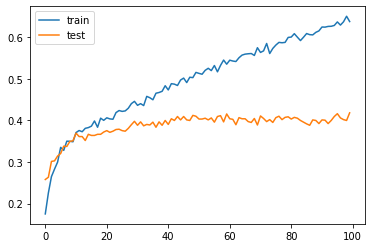

In [ ]:
plt.plot(history_chroma.history['accuracy'], label='train')
plt.plot(history_chroma.history['val_accuracy'], label='test')
plt.legend()
plt.show()

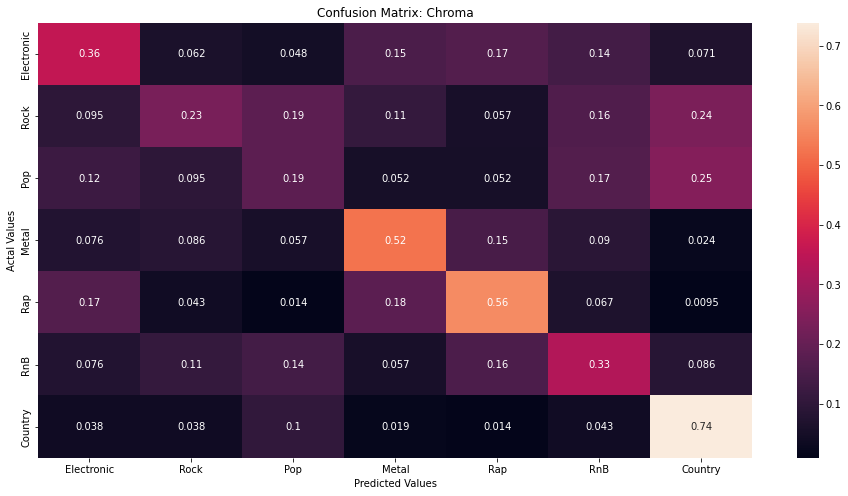

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = model_chroma.predict(x_test_chroma)
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
cm_df = pd.DataFrame(cm*genre_count/cm.sum(), index = genre_labels, columns = genre_labels)

#Plotting the confusion matrix
plt.figure(figsize=(16,8))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix: Chroma')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=genre_labels))


Classification Report

              precision    recall  f1-score   support

  Electronic       0.38      0.36      0.37       209
        Rock       0.35      0.22      0.27       227
         Pop       0.25      0.20      0.22       195
       Metal       0.48      0.52      0.50       211
         Rap       0.49      0.54      0.51       219
         RnB       0.33      0.34      0.34       200
     Country       0.52      0.74      0.61       209

    accuracy                           0.42      1470
   macro avg       0.40      0.42      0.40      1470
weighted avg       0.40      0.42      0.40      1470



In [ ]:
model_test_inputs = [x_test_mfcc, x_test_chroma]
from sklearn.metrics import accuracy_score

models = [model_mfcc, model_chroma]
#def ensemble_predictions():
	# make predictions
y_test_preds = [model.predict(model_test_inputs[i]) for i, model in enumerate(models)]
	# sum across ensemble members
y_test_pred_ensemble_sum = np.sum(np.array(y_test_preds), axis=0)


accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_test_pred_ensemble_sum, axis=1))

0.5285714285714286

In [ ]:
#track_count = len(track_genre_df.index.values)
wordvec_len = 5000

lyric_values = np.zeros((track_count, wordvec_len), dtype=np.float32)

for i, track_id in enumerate(track_genre_df.index.values):
    lyric_values[i] = np.array(lyric_df[lyric_df.index == track_id]['wordvec'].values[0])

In [ ]:
#TF-IDF
lyric_values_tf_idf = np.zeros((track_count, wordvec_len), dtype=np.float32)
lyric_values_docfreqs = np.zeros((wordvec_len), dtype=np.float32)
#lyric_values_docfreqs = np.sum((lyric_values), axis=0)
#lyric_values_docfreqs = np.sum((lyric_values > 1), axis=0)
for i in range(track_count):
  for j in range(wordvec_len):
    if lyric_values[i][j] > 0:
      lyric_values_docfreqs[j] = lyric_values_docfreqs[j] + 1

lyric_values_docwordcounts = np.sum(lyric_values, axis=1)

for i in range(track_count):
  for  j in range(wordvec_len):
    if lyric_values[i][j] > 0:
      termfreq = lyric_values[i][j]/lyric_values_docwordcounts[i]
      docfreq = lyric_values_docfreqs[j]
      idocfreq = np.log(track_count/(docfreq))
      tf_idf = termfreq*idocfreq
      lyric_values_tf_idf[i][j] = tf_idf

In [ ]:
#TF-IGM (Inverse Gravity Moment)
tf_igm_lambda = 7

term_class_specific_frequency = np.zeros((wordvec_len, genre_count), dtype=np.float32)
for i, track_id in enumerate(track_genre_df.index.values):
  genre_index = np.argmax(msdi_genres[i])
  term_freqs = np.array(lyric_df[lyric_df.index == track_id]['wordvec'].values[0])
  term_class_specific_frequency[::,genre_index] = term_class_specific_frequency[::, genre_index] + term_freqs

sum_ranked_term_class_specific_frequency = np.zeros((wordvec_len), dtype=np.float32)
for i in range(wordvec_len):
  val = 0
  freqs = np.copy(term_class_specific_frequency[i])
  for j in range(genre_count):
    val = val+ (j+1)*max(freqs)
    freqs[np.argmax(freqs)] = 0
  sum_ranked_term_class_specific_frequency[i] = val

lyric_values_tf_rigm = np.zeros((track_count, wordvec_len), dtype=np.float32)

for i in range(track_count):
  genre_index = np.argmax(msdi_genres[i])
  for  j in range(wordvec_len):
    if lyric_values[i][j] > 0:
      termfreq = lyric_values[i][j]/lyric_values_docwordcounts[i]
      tfigm = np.sqrt(termfreq)*(1+(tf_igm_lambda*(term_class_specific_frequency[j][genre_index]/sum_ranked_term_class_specific_frequency[j])))
      lyric_values_tf_rigm[i][j] = tfigm

In [ ]:
x_train_lyric, x_test_lyric = train_test_split(lyric_values, test_size=modelling_test_size, random_state=1)
#lyric_values = None

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings

warnings.filterwarnings('ignore')
x_train = x_train_lyric

grid={"C":[0.001, 0.01, 0.1, 1, 10], 'solver':['lbfgs', 'sag', 'newton-cg']} #only l2 supported

logreg = LogisticRegression(multi_class='multinomial')
gcv=GridSearchCV(logreg,grid,cv=5,scoring='accuracy')
gcv.fit(x_train, np.argmax(y_train, axis=1))

print("tuned hpyerparameters :(best parameters) ",gcv.best_params_)
print("accuracy :",gcv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'solver': 'newton-cg'}
accuracy : 0.4574344023323615


Test accuracies:
wordvec
tf-idf
rtf-igm

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings

warnings.filterwarnings('ignore')
x_train = x_train_lyric
x_test = x_test_lyric

model = LogisticRegression(multi_class='multinomial', C=0.01, solver='newton-cg')

model.fit(x_train, np.argmax(y_train, axis=1))
y_test_pred = model.predict(x_test)
print("test accuracy : ", accuracy_score(np.argmax(y_test, axis=1), y_test_pred))

test accuracy :  0.47210884353741495


In [ ]:
def get_lyric_model(input_shape, num_classes):

  model = Sequential()
  model.add(Dense(512, input_shape=input_shape, activation='relu', kernel_initializer='he_uniform'))
  #model.add(BatchNormalization())

  model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dropout(0.5))

  model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dropout(0.5))

  model.add(Dense(num_classes, activation='softmax', kernel_initializer='he_uniform'))

  model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])
  #model.summary
  return model

Test accuracies:
wordvec: 46.2, 
tf-idf 46.4, 
rtf-igm 48.8

In [ ]:
input_shape = x_train_lyric[0].shape
model = get_lyric_model(input_shape, genre_count)
x_train = x_train_lyric
x_test = x_test_lyric

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history_lyric = model.fit(x_train, y_train, epochs=50, batch_size=512, callbacks=[callback], verbose=1, validation_data=(x_test, y_test))
model_lyric = model

Epoch 1/50
7/7 [==============================] - 1s 53ms/step - loss: 2.3460 - accuracy: 0.1968 - val_loss: 1.7480 - val_accuracy: 0.2946
Epoch 2/50
7/7 [==============================] - 0s 29ms/step - loss: 1.7684 - accuracy: 0.3035 - val_loss: 1.6480 - val_accuracy: 0.3898
Epoch 3/50
7/7 [==============================] - 0s 24ms/step - loss: 1.5893 - accuracy: 0.4143 - val_loss: 1.5637 - val_accuracy: 0.4163
Epoch 4/50
7/7 [==============================] - 0s 28ms/step - loss: 1.4272 - accuracy: 0.4802 - val_loss: 1.4928 - val_accuracy: 0.4524
Epoch 5/50
7/7 [==============================] - 0s 24ms/step - loss: 1.2695 - accuracy: 0.5522 - val_loss: 1.4566 - val_accuracy: 0.4687
Epoch 6/50
7/7 [==============================] - 0s 24ms/step - loss: 1.0859 - accuracy: 0.6224 - val_loss: 1.4201 - val_accuracy: 0.4871
Epoch 7/50
7/7 [==============================] - 0s 25ms/step - loss: 0.9007 - accuracy: 0.6939 - val_loss: 1.4494 - val_accuracy: 0.4878
Epoch 8/50
7/7 [===========

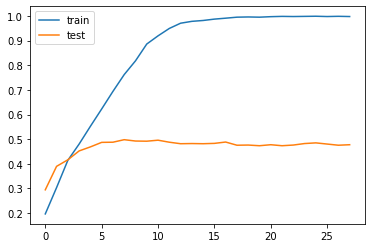

In [ ]:
plt.plot(history_lyric.history['accuracy'], label='train')
plt.plot(history_lyric.history['val_accuracy'], label='test')
plt.legend()
plt.show()

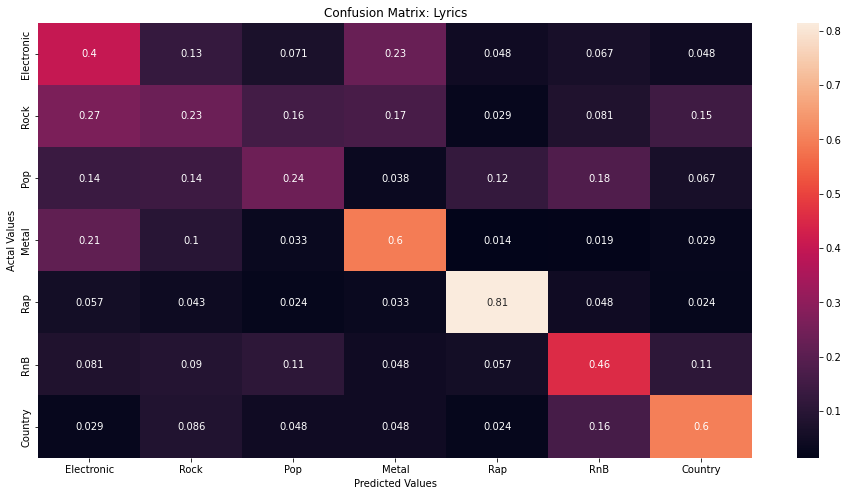

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = model_lyric.predict(x_test_lyric)
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
cm_df = pd.DataFrame(cm*genre_count/cm.sum(), index = genre_labels, columns = genre_labels)

#Plotting the confusion matrix
plt.figure(figsize=(16,8))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix: Lyrics')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=genre_labels))


Classification Report

              precision    recall  f1-score   support

  Electronic       0.34      0.41      0.37       209
        Rock       0.28      0.22      0.25       227
         Pop       0.35      0.26      0.30       195
       Metal       0.51      0.59      0.55       211
         Rap       0.73      0.78      0.76       219
         RnB       0.45      0.48      0.46       200
     Country       0.59      0.60      0.59       209

    accuracy                           0.48      1470
   macro avg       0.47      0.48      0.47      1470
weighted avg       0.47      0.48      0.47      1470



In [ ]:
image_row = 64
image_col = 64
image_ch = 3

msdi_aart_images = np.zeros((track_count, image_row, image_col, image_ch), dtype=np.float32)

for i, track_id in enumerate(track_genre_df.index.values):
    filepath = 'aart_data/' + track_id[2] + '/' + track_id[3] + '/' + track_id[4] + '/' + track_id + '.jpg'
    raw_img = tf.io.read_file(filepath)
    img_decoded = tf.image.decode_jpeg(raw_img)
    img_tmp = tf.image.resize(img_decoded, [image_row, image_col])
    immax = img_tmp.numpy().max()
    immin = img_tmp.numpy().min()
    imrange = 1
    if immax > immin:
        imrange = (immax-immin)
    img_norm = (img_tmp - immin)/imrange
    msdi_aart_images[i] = ((img_norm * 2) - 1)

In [ ]:
x_train_aart, x_test_aart = train_test_split(msdi_aart_images, test_size=modelling_test_size, random_state=1)
msdi_aart_images = None

In [ ]:
def get_aart_model(input_shape, num_classes):

  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape, activation='relu', kernel_initializer='he_uniform'))

  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))

  model.add(Flatten())

  model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dropout(0.5))

  model.add(Dense(num_classes, activation='softmax', kernel_initializer='he_uniform'))

  model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])
  #model.summary
  return model

In [ ]:
input_shape = x_train_aart[0].shape
model = get_aart_model(input_shape, genre_count)
x_train = x_train_aart
x_test = x_test_aart

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history_aart = model.fit(x_train, y_train, epochs=100, batch_size=64, callbacks=[callback], verbose=1, validation_data=(x_test, y_test))
model_aart = model

Epoch 1/100
54/54 [==============================] - 2s 34ms/step - loss: 2.2212 - accuracy: 0.1388 - val_loss: 1.9453 - val_accuracy: 0.1401
Epoch 2/100
54/54 [==============================] - 2s 29ms/step - loss: 1.9428 - accuracy: 0.1414 - val_loss: 1.9405 - val_accuracy: 0.1449
Epoch 3/100
54/54 [==============================] - 1s 26ms/step - loss: 1.9394 - accuracy: 0.1513 - val_loss: 1.9351 - val_accuracy: 0.1483
Epoch 4/100
54/54 [==============================] - 1s 26ms/step - loss: 1.9362 - accuracy: 0.1487 - val_loss: 1.9340 - val_accuracy: 0.1483
Epoch 5/100
54/54 [==============================] - 2s 28ms/step - loss: 1.9327 - accuracy: 0.1516 - val_loss: 1.9329 - val_accuracy: 0.1469
Epoch 6/100
54/54 [==============================] - 1s 26ms/step - loss: 1.9317 - accuracy: 0.1484 - val_loss: 1.9324 - val_accuracy: 0.1422
Epoch 7/100
54/54 [==============================] - 1s 26ms/step - loss: 1.9292 - accuracy: 0.1560 - val_loss: 1.9304 - val_accuracy: 0.1435
Epoch 

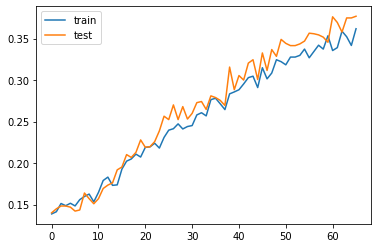

In [ ]:
plt.plot(history_aart.history['accuracy'], label='train')
plt.plot(history_aart.history['val_accuracy'], label='test')
plt.legend()
plt.show()

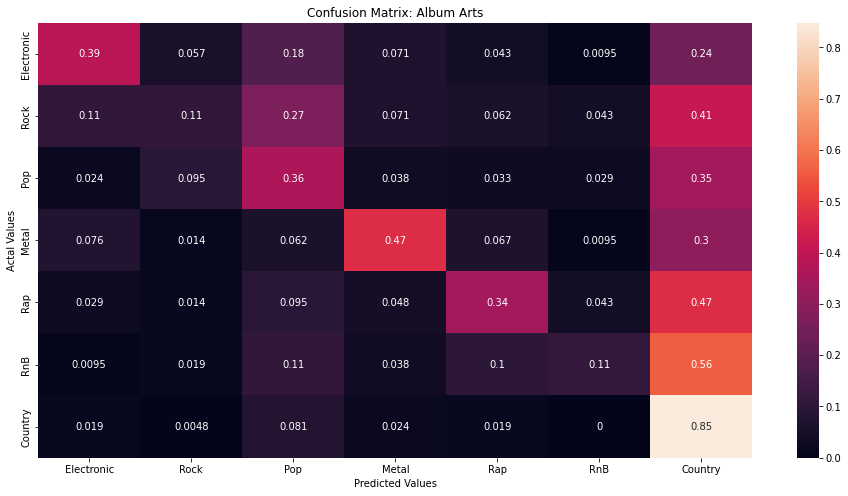

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = model_aart.predict(x_test_aart)
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
cm_df = pd.DataFrame(cm*genre_count/cm.sum(), index = genre_labels, columns = genre_labels)

#Plotting the confusion matrix
plt.figure(figsize=(16,8))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix: Album Arts')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=genre_labels))


Classification Report

              precision    recall  f1-score   support

  Electronic       0.59      0.39      0.47       209
        Rock       0.35      0.10      0.16       227
         Pop       0.31      0.39      0.35       195
       Metal       0.62      0.47      0.53       211
         Rap       0.51      0.33      0.40       219
         RnB       0.46      0.12      0.19       200
     Country       0.27      0.85      0.41       209

    accuracy                           0.38      1470
   macro avg       0.44      0.38      0.36      1470
weighted avg       0.45      0.38      0.36      1470



In [ ]:
feature_count = 3

msdi_misc_feature_values = np.zeros((track_count, feature_count), dtype=np.float32)

for i, track_id in enumerate(track_genre_df.index.values):
    base_dir = 'msd_data/' + track_id[2] + '/' + track_id[3] + '/' + track_id[4]
    filepath = base_dir + '/' + track_id + '.h5'
    try:
      hfile = h5py.File(filepath, 'r')

      msdi_misc_feature_values[0] = hfile['analysis']['songs']['loudness'][0] #loudness: general loudness of the track
      msdi_misc_feature_values[1] = hfile['analysis']['songs']['tempo'][0] #tempo: tempo in BPM according to The Echo Nest
      msdi_misc_feature_values[2] = hfile['musicbrainz']['songs']['year'][0] #year: year when this song was released, according to musicbrainz.org

    except (RuntimeError, TypeError, NameError, OSError):
      print('failed for file: ', filepath)

In [ ]:
x_train_misc_features, x_test_misc_features = train_test_split(msdi_misc_feature_values, test_size=modelling_test_size, random_state=1)
msdi_misc_feature_values = None

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings

warnings.filterwarnings('ignore')
x_train = x_train_misc_features

grid={"C":[0.001, 0.01, 0.1, 1, 10], 'solver':['lbfgs', 'sag', 'newton-cg']} #only l2 supported

logreg = LogisticRegression(multi_class='multinomial')
gcv=GridSearchCV(logreg,grid,cv=10,scoring='accuracy')
gcv.fit(x_train, np.argmax(y_train, axis=1))

print("tuned hpyerparameters :(best parameters) ",gcv.best_params_)
print("accuracy :",gcv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.001, 'solver': 'lbfgs'}
accuracy : 0.14723032069970846


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings

warnings.filterwarnings('ignore')
x_train = x_train_misc_features
x_test = x_test_misc_features

model = LogisticRegression(multi_class='multinomial', C=.001, solver='lbfgs')

model.fit(x_train, np.argmax(y_train, axis=1))
y_test_pred = model.predict(x_test)
print("test accuracy : ", accuracy_score(np.argmax(y_test, axis=1), y_test_pred))

test accuracy :  0.1326530612244898


In [ ]:
def get_misc_feature_model(input_shape, num_classes):

  model = Sequential()
  model.add(Dense(512, input_shape=input_shape, activation='relu', kernel_initializer='he_uniform'))
  #model.add(BatchNormalization())

  model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dropout(0.25))

  model.add(Dense(num_classes, activation='softmax', kernel_initializer='he_uniform'))

  model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])
  #model.summary
  return model

In [ ]:
input_shape = x_train_misc_features[0].shape
model = get_misc_feature_model(input_shape, genre_count)
x_train = x_train_misc_features
x_test = x_test_misc_features

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history_misc_feature = model.fit(x_train, y_train, epochs=100, batch_size=512, callbacks=[callback], verbose=1, validation_data=(x_test, y_test))
model_misc_feature = model

Epoch 1/100
7/7 [==============================] - 1s 38ms/step - loss: 2.4465 - accuracy: 0.1429 - val_loss: 2.3896 - val_accuracy: 0.1327
Epoch 2/100
7/7 [==============================] - 0s 12ms/step - loss: 1.9448 - accuracy: 0.1475 - val_loss: 2.9105 - val_accuracy: 0.1327
Epoch 3/100
7/7 [==============================] - 0s 13ms/step - loss: 1.9447 - accuracy: 0.1475 - val_loss: 3.1550 - val_accuracy: 0.1327
Epoch 4/100
7/7 [==============================] - 0s 12ms/step - loss: 1.9448 - accuracy: 0.1475 - val_loss: 3.3164 - val_accuracy: 0.1327
Epoch 5/100
7/7 [==============================] - 0s 12ms/step - loss: 1.9447 - accuracy: 0.1475 - val_loss: 3.3961 - val_accuracy: 0.1327
Epoch 6/100
7/7 [==============================] - 0s 11ms/step - loss: 1.9447 - accuracy: 0.1475 - val_loss: 3.4141 - val_accuracy: 0.1327
Epoch 7/100
7/7 [==============================] - 0s 11ms/step - loss: 1.9449 - accuracy: 0.1440 - val_loss: 3.4084 - val_accuracy: 0.1327
Epoch 8/100
7/7 [===

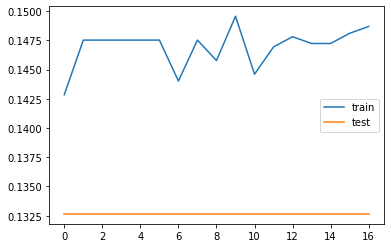

In [ ]:
plt.plot(history_misc_feature.history['accuracy'], label='train')
plt.plot(history_misc_feature.history['val_accuracy'], label='test')
plt.legend()
plt.show()

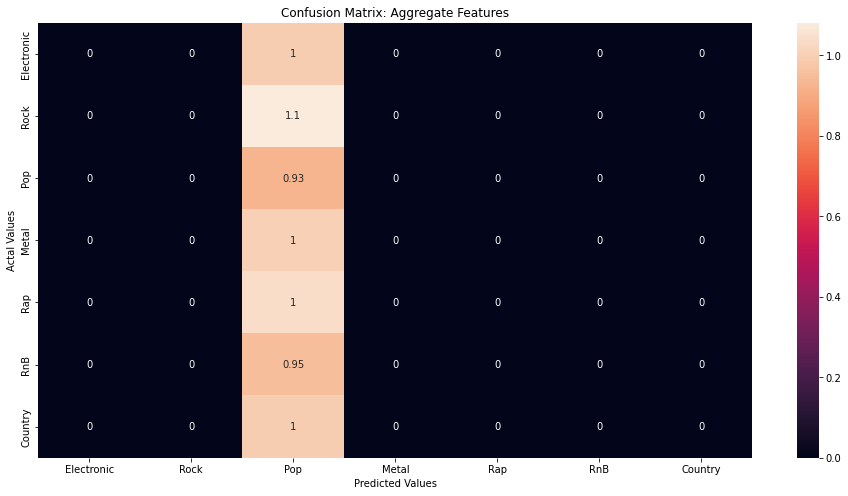

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = model_misc_feature.predict(x_test_misc_features)
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
cm_df = pd.DataFrame(cm*genre_count/cm.sum(), index = genre_labels, columns = genre_labels)

#Plotting the confusion matrix
plt.figure(figsize=(16,8))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix: Aggregate Features')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=genre_labels))


Classification Report

              precision    recall  f1-score   support

  Electronic       0.00      0.00      0.00       209
        Rock       0.00      0.00      0.00       227
         Pop       0.13      1.00      0.23       195
       Metal       0.00      0.00      0.00       211
         Rap       0.00      0.00      0.00       219
         RnB       0.00      0.00      0.00       200
     Country       0.00      0.00      0.00       209

    accuracy                           0.13      1470
   macro avg       0.02      0.14      0.03      1470
weighted avg       0.02      0.13      0.03      1470



In [ ]:
models = [model_mfcc, model_chroma, model_lyric, model_aart, model_misc_feature]
model_names = ['model_mfcc', 'model_chroma', 'model_lyric', 'model_aart', 'model_misc_feature']

In [ ]:
!rm -rf models_bkp.zip
for i, model in enumerate(models):
  cmd = r'rm -rf ' + model_names[i]
  os.system(cmd)
  model.save(model_names[i])

INFO:tensorflow:Assets written to: model_mfcc/assets
INFO:tensorflow:Assets written to: model_chroma/assets
INFO:tensorflow:Assets written to: model_lyric/assets
INFO:tensorflow:Assets written to: model_aart/assets
INFO:tensorflow:Assets written to: model_misc_feature/assets


In [ ]:
!ls

aart_data      model_aart    model_mfcc		 msd_data.zip
aart_data.zip  model_chroma  model_misc_feature  sample_data
lyric_df.pkl   model_lyric   msd_data		 shortlisted_tracks_df.pkl


In [ ]:
!zip -r models_bkp.zip model_mfcc model_chroma model_lyric model_aart model_misc_feature
!ls  

  adding: model_mfcc/ (stored 0%)
  adding: model_mfcc/saved_model.pb (deflated 88%)
  adding: model_mfcc/keras_metadata.pb (deflated 89%)
  adding: model_mfcc/assets/ (stored 0%)
  adding: model_mfcc/variables/ (stored 0%)
  adding: model_mfcc/variables/variables.data-00000-of-00001 (deflated 10%)
  adding: model_mfcc/variables/variables.index (deflated 64%)
  adding: model_chroma/ (stored 0%)
  adding: model_chroma/saved_model.pb (deflated 89%)
  adding: model_chroma/keras_metadata.pb (deflated 89%)
  adding: model_chroma/assets/ (stored 0%)
  adding: model_chroma/variables/ (stored 0%)
  adding: model_chroma/variables/variables.data-00000-of-00001 (deflated 13%)
  adding: model_chroma/variables/variables.index (deflated 64%)
  adding: model_lyric/ (stored 0%)
  adding: model_lyric/saved_model.pb (deflated 89%)
  adding: model_lyric/keras_metadata.pb (deflated 89%)
  adding: model_lyric/assets/ (stored 0%)
  adding: model_lyric/variables/ (stored 0%)
  adding: model_lyric/variables/v

In [ ]:
#''' uncomment to load models
# TAKE ID FROM SHAREABLE LINK
#https://drive.google.com/file/d/1_GdvevUFAircgpBofeVtToNqVwzdcA45/view?usp=sharing
file_id = r'1_GdvevUFAircgpBofeVtToNqVwzdcA45'
# DESTINATION FILE ON YOUR DISK
destination = 'models_bkp.zip' 
download_file_from_google_drive(file_id, destination)
#'''

In [ ]:
for i, model in enumerate(models):
  cmd = r'rm -rf ' + model_names[i]
  os.system(cmd)
  print('deleting model folder: ', cmd)
!ls

NameError: ignored

In [ ]:
!unzip -q models_bkp.zip
!ls

aart_data      model_chroma	   models_bkp.zip  shortlisted_tracks_df.pkl
aart_data.zip  model_lyric	   msd_data
lyric_df.pkl   model_mfcc	   msd_data.zip
model_aart     model_misc_feature  sample_data


In [ ]:
#''' uncomment to load models
models = []
model_names = ['model_mfcc', 'model_chroma', 'model_lyric', 'model_aart']#, 'model_misc_feature']
for name in model_names:
  models.append(keras.models.load_model(name))
#'''

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp models_bkp.zip /content/drive/MyDrive/

In [ ]:
from sklearn.metrics import accuracy_score

model_test_inputs = [x_test_mfcc, x_test_chroma, x_test_lyric, x_test_aart]
#models = [model_mfcc, model_chroma, model_lyric, model_aart]

#def ensemble_predictions():
	# make predictions
y_test_preds = [model.predict(model_test_inputs[i]) for i, model in enumerate(models)]
	# sum across ensemble members
y_test_pred_ensemble_sum = np.sum(np.array(y_test_preds), axis=0)

accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_test_pred_ensemble_sum, axis=1))

0.6068027210884354

In [ ]:
from sklearn.metrics import accuracy_score

model_test_inputs = [x_test_mfcc, x_test_chroma, x_test_lyric, x_test_aart]
models = [model_mfcc, model_chroma, model_lyric, model_aart]

#def ensemble_predictions():
	# make predictions
y_test_preds = [model.predict(model_test_inputs[i]) for i, model in enumerate(models)]
	# sum across ensemble members
y_test_pred_ensemble_sum = np.sum(np.array(y_test_preds), axis=0)

accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_test_pred_ensemble_sum, axis=1))

0.6068027210884354

In [ ]:
from sklearn.metrics import accuracy_score

model_test_inputs = [x_test_mfcc, x_test_chroma, x_test_lyric, x_test_aart]
#models = [model_mfcc, model_chroma, model_lyric, model_aart]

#def ensemble_predictions():
	# make predictions
y_test_preds = [model.predict(model_test_inputs[i]) for i, model in enumerate(models)]
y_test_preds_np = np.array(y_test_preds)
	# sum across ensemble members
for i in range(y_test_preds_np.shape[0]):
  for j in range(y_test_preds_np.shape[1]):
    index = np.argmax(y_test_preds_np[i][j])
    y_test_preds_np[i][j][index] = 1
y_test_pred_ensemble_sum = np.sum(y_test_preds_np, axis=0)

accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_test_pred_ensemble_sum, axis=1))

0.6231292517006802

In [ ]:
from sklearn.metrics import accuracy_score

model_test_inputs = [x_test_mfcc, x_test_chroma, x_test_lyric, x_test_aart]
#models = [model_mfcc, model_chroma, model_lyric, model_aart]
model_accuracies = [0.52, 0.42, 0.48, 0.37]
#model_weights = [np.log(p/(1-p)) for p in model_accuracies]
model_weights = model_accuracies
#model_weights = [1,1,1,1]

#def ensemble_predictions():
	# make predictions
y_test_preds = [model.predict(model_test_inputs[i]) for i, model in enumerate(models)]
y_test_preds_np = np.array(y_test_preds)
	# sum across ensemble members
for i in range(y_test_preds_np.shape[0]):
  for j in range(y_test_preds_np.shape[1]):
    index = np.argmax(y_test_preds_np[i][j])
    y_test_preds_np[i][j][index] = 1
	# sum across ensemble members
y_test_pred_ensemble_sum = np.tensordot(np.array(y_test_preds_np), np.array(model_weights), axes=((0),(0)))

accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_test_pred_ensemble_sum, axis=1))

0.617687074829932

In [ ]:
from sklearn.metrics import accuracy_score

model_test_inputs = [x_test_mfcc, x_test_chroma, x_test_lyric, x_test_aart]
#models = [model_mfcc, model_chroma, model_lyric, model_aart]
model_accuracies = [0.52, 0.42, 0.48, 0.37]
model_weights = [100*np.log(p/(1-p)) for p in model_accuracies]
#model_weights = model_accuracies
#model_weights = [1,1,1,1]

#def ensemble_predictions():
	# make predictions
y_test_preds = [model.predict(model_test_inputs[i]) for i, model in enumerate(models)]
'''y_test_preds_np = np.array(y_test_preds)
	# sum across ensemble members
for i in range(y_test_preds_np.shape[0]):
  for j in range(y_test_preds_np.shape[1]):
    index = np.argmax(y_test_preds_np[i][j])
    y_test_preds_np[i][j][index] = 1
	'''# sum across ensemble members
y_test_pred_ensemble_sum = np.tensordot(np.array(y_test_preds), np.array(model_weights), axes=((0),(0)))

accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_test_pred_ensemble_sum, axis=1))

0.04353741496598639

In [ ]:
model_weights

[8.004270767353656,
 -32.277339226305116,
 -8.004270767353649,
 -53.22168137473082]

In [ ]:
y_test_pred_ensemble_sum

array([[3.        , 0.48691565, 0.3314306 , ..., 0.03559726, 0.0859615 ,
        1.7975464 ],
       [3.        , 0.91536945, 0.2203044 , ..., 0.81932515, 0.59758186,
        0.14262219],
       [3.        , 0.19572201, 0.13651457, ..., 0.00635671, 0.00963621,
        2.6426616 ],
       ...,
       [3.        , 0.08284047, 0.23350047, ..., 1.5521953 , 0.37546253,
        0.02303913],
       [3.        , 0.09678163, 0.05083098, ..., 0.17140123, 0.03775009,
        0.00923255],
       [3.        , 0.10090341, 0.03753807, ..., 0.4911609 , 0.07235859,
        0.00355663]], dtype=float32)

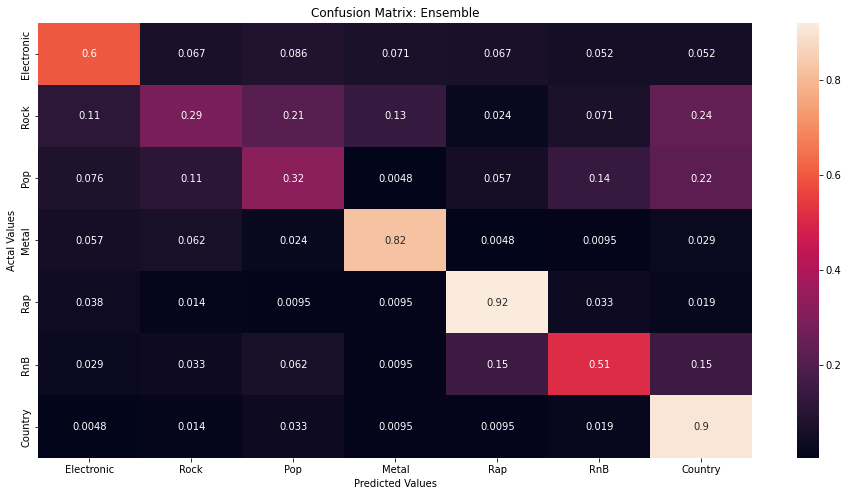

In [ ]:
from sklearn.metrics import confusion_matrix
#y_pred = model_misc_feature.predict(x_test_misc_features)
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_test_pred_ensemble_sum, axis=1))
cm_df = pd.DataFrame(cm*genre_count/cm.sum(), index = genre_labels, columns = genre_labels)

#Plotting the confusion matrix
plt.figure(figsize=(16,8))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix: Ensemble')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print('\nClassification Report Ensemble\n')
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_test_pred_ensemble_sum, axis=1), target_names=genre_labels))


Classification Report Ensemble

              precision    recall  f1-score   support

  Electronic       0.65      0.60      0.63       209
        Rock       0.49      0.26      0.34       227
         Pop       0.43      0.34      0.38       195
       Metal       0.77      0.82      0.79       211
         Rap       0.75      0.88      0.81       219
         RnB       0.61      0.54      0.57       200
     Country       0.56      0.91      0.69       209

    accuracy                           0.62      1470
   macro avg       0.61      0.62      0.60      1470
weighted avg       0.61      0.62      0.60      1470



In [ ]:
observed_accuracy = 0.62
random_accuracy = 1/7

kappa = (observed_accuracy-random_accuracy)/(1-random_accuracy)
kappa

0.5566666666666666

In [ ]:
observed_accuracy = 0.477
random_accuracy = 1/15

kappa = (observed_accuracy-random_accuracy)/(1-random_accuracy)
kappa

0.4396428571428571

In [12]:
observed_accuracy = 0.49
random_accuracy = 1/15

kappa = (observed_accuracy-random_accuracy)/(1-random_accuracy)
kappa

0.45357142857142857

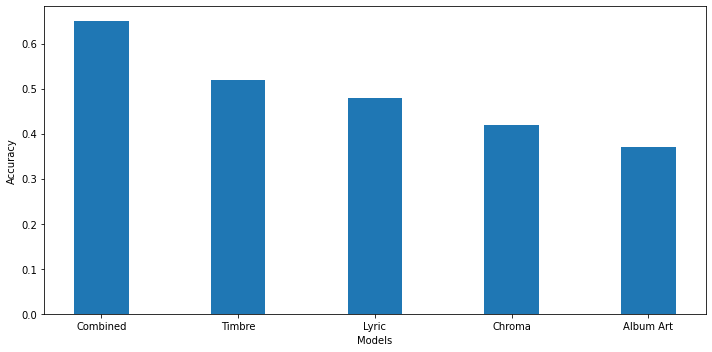

In [7]:
model_accuracies = [0.65, 0.52, 0.48, 0.42, 0.37]
model_names = ['Combined', 'Timbre', 'Lyric', 'Chroma', 'Album Art']


fig, ax = plt.subplots(figsize = (10,5))
ax.bar(model_names,model_accuracies,width=0.4)

#for index,data in enumerate(model_accuracies):
#    plt.text(x=index, y =str(data)+ '%', s=f"{data}" , fontdict=dict(fontsize=20))
ax.set_ylabel('Accuracy')
ax.set_xlabel('Models')
plt.tight_layout()
plt.show()